In [1]:
import pandas as pd
import numpy as np
import glob
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Point
from pyproj import CRS


In [2]:
years = list(range(2015,2022+1))
appended_data = pd.DataFrame()

for y in years:
    df_years = pd.read_csv('../../data/Data_NO2/'+ str(y) + '.csv')
    # df_years = df_years.drop(columns=['Site no','Grid squaresX', 'Grid squaresY', 'Site Type'])
    df_years = df_years.drop(columns=['Site no', 'Site Type'])
    # df_years = (df_years.set_index(['Location'])
    df_years = (df_years.set_index(['Location','Grid squaresX', 'Grid squaresY'])
            .stack()
            .reset_index(name='Value')
            .rename(columns={'level_3':'Date'}))
    appended_data = appended_data.append(df_years,ignore_index=True)

/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_5342/1725163454.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  appended_data = appended_data.append(df_years,ignore_index=True)
/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_5342/1725163454.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  appended_data = appended_data.append(df_years,ignore_index=True)
/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_5342/1725163454.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  appended_data = appended_data.append(df_years,ignore_index=True)
/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_5342/1725163454.py:13: FutureWarning: The frame.append method is deprecated and will be removed

In [3]:
# Prepare lat/lon in the right coordinate system
from convertbng.util import convert_bng, convert_lonlat
eastings = appended_data["Grid squaresX"]
northings = appended_data["Grid squaresY"]
lon, lat = convert_lonlat(eastings, northings)
appended_data['lat'] = lat
appended_data['lon'] = lon
appended_data = appended_data.drop(columns=['Grid squaresX', 'Grid squaresY'])

In [4]:
# Prepare format for each NO2 measurement location

NO2_locations = appended_data
NO2_locations = NO2_locations.drop(columns=['Date', 'Value'])
NO2_locations = NO2_locations.drop_duplicates(subset=['Location'])
NO2_locations = NO2_locations.set_index('Location').T.to_dict('list')

geometry = [Point(reversed(v)) for _, v in NO2_locations.items()]

crs = CRS.from_epsg(4326)
NO2_locations_gpd = gpd.GeoDataFrame(geometry=geometry, crs=crs)
NO2_locations_gpd = NO2_locations_gpd.to_crs(epsg=3857)

In [5]:
# Set bounds
crs = CRS.from_epsg(4326)
min_lat, min_lon, max_lat, max_lon = 51.510000, -0.078000, 51.536322, -0.035000
bounds = gpd.GeoDataFrame(
    geometry=[Point([min_lon, min_lat]), Point([max_lon, max_lat])], crs=crs
)
minx, miny, maxx, maxy = bounds.to_crs(epsg=3857).total_bounds

In [6]:
path_census = (
    "../../data/Census_Residential_Data_Pack_2011/Local_Authority_Districts/E09000030/"
)
lsoas_link = path_census + "shapefiles/E09000030.shp"
df = gpd.read_file(lsoas_link)
df = df.to_crs(epsg=3857)

In [7]:
def plot(df, metrics, cmaps):
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 20))
    axes = axes if isinstance(axes, np.ndarray) else [axes]
    # cmap = sns.color_palette("crest", as_cmap=True)
    for ax, metric, cmap in zip(axes, metrics, cmaps):
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

        # title = 'Multiple deprivation index per LSOA in Tower Hamlets'
        ax.set_title(metric, fontdict={"fontsize": "15", "fontweight": "3"})
        ax.axis("off")

        df.plot(ax=ax, alpha=0.8, edgecolor="k", column=metric, cmap=cmap)
        NO2_locations_gpd.plot(
            ax=ax,
            markersize=200,
            color="red",
            marker="*",
            label="modal filters",
            zorder=3,
        )
        sm = plt.cm.ScalarMappable(
            cmap=cmap, norm=plt.Normalize(vmin=df[metric].min(), vmax=df[metric].max())
        )  # empty array for the data range
        cbar = fig.colorbar(sm, shrink=0.4, ax=ax)
        cx.add_basemap(ax)
        ax.legend()
    fig.tight_layout()
    return fig

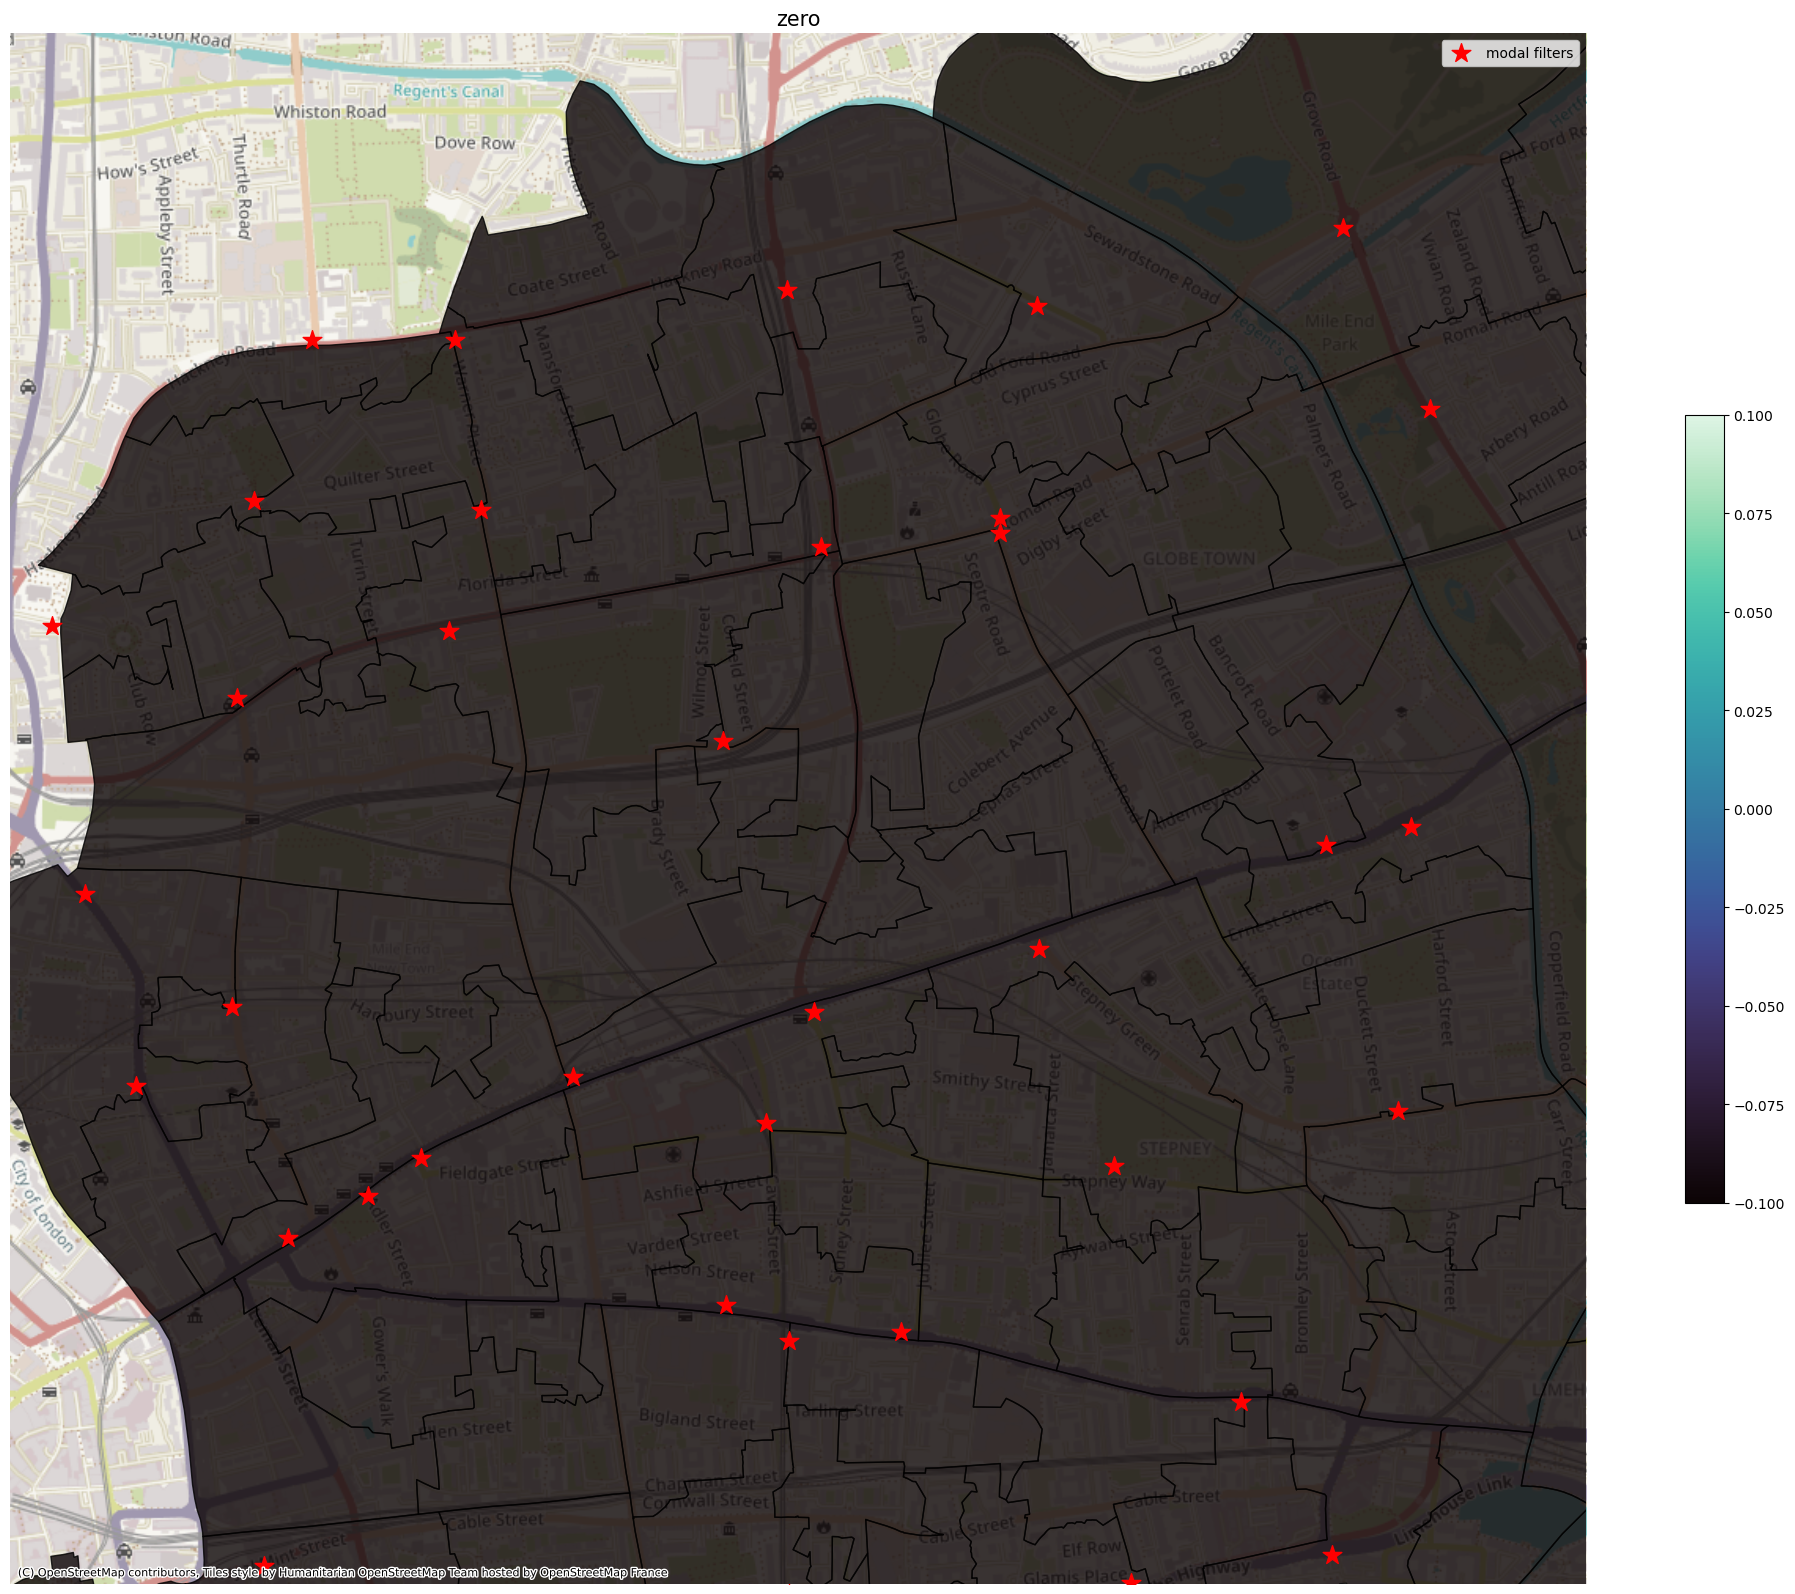

In [8]:
df['zero'] = 0
metrics = ['zero']
cmaps = [
    sns.color_palette("mako", as_cmap=True),
    sns.color_palette("mako_r", as_cmap=True),
]

out = plot(df, metrics, cmaps)